Import Libraries

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [144]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\Dell\AppData\Local\Temp\ipykernel_9044\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import shap

Load Dataset (Telco Customer Churn Dataset from Kaggle)

In [16]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Data Cleaning and Inspection

In [19]:
print("\nInitial Data Types:")
print(data.dtypes)

# Strip whitespace from object columns
to_strip = data.select_dtypes(include='object').columns
for col in to_strip:
    data[col] = data[col].str.strip()

# Convert TotalCharges to numeric again after stripping
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')




Initial Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [21]:
# Handle missing TotalCharges values BEFORE EDA
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

In [23]:
# Convert binary columns to 0 and 1 (Note: This step isn't strictly required for modeling if using get_dummies later, but improves clarity during EDA)
binary_columns = [
    'PhoneService', 'Partner', 'Dependents', 'PaperlessBilling',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in binary_columns:
    if col in data.columns:
        data[col] = data[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Convert gender and Churn columns to binary 0/1 (optional but helps with clarity)
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Additional binary cleanup for SeniorCitizen (convert to boolean)
data['SeniorCitizen'] = data['SeniorCitizen'].astype(bool)

# Convert other binary columns to boolean, though not strictly necessary for modeling
data['gender'] = data['gender'].astype(bool)
data['Churn'] = data['Churn'].astype(bool)
for col in binary_columns:
    if col in data.columns:
        data[col] = data[col].astype(bool)

print("\nData Types After Cleanup:")
print(data.dtypes)



Data Types After Cleanup:
customerID           object
gender                 bool
SeniorCitizen          bool
Partner                bool
Dependents             bool
tenure                int64
PhoneService           bool
MultipleLines          bool
InternetService      object
OnlineSecurity         bool
OnlineBackup           bool
DeviceProtection       bool
TechSupport            bool
StreamingTV            bool
StreamingMovies        bool
Contract             object
PaperlessBilling       bool
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                  bool
dtype: object


In [25]:
print("\nMissing Values Per Column:")
print(data.isnull().sum())


Missing Values Per Column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Exploratory Data Analysis

In [28]:
print("First 5 rows of data:")
print(data.head())

print("\nData Info:")
print(data.info())

print("\nSummary Statistics:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())


First 5 rows of data:
   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG   False          False     True       False       1   
1  5575-GNVDE    True          False    False       False      34   
2  3668-QPYBK    True          False    False       False       2   
3  7795-CFOCW    True          False    False       False      45   
4  9237-HQITU   False          False    False       False       2   

   PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0         False          False             DSL           False  ...   
1          True          False             DSL            True  ...   
2          True          False             DSL            True  ...   
3         False          False             DSL            True  ...   
4          True          False     Fiber optic           False  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0             False        False        False            False   
1   

In [30]:
print("\nChurn Value Counts:")
print(data['Churn'].value_counts())
print("\nChurn Percentage Breakdown:")
print(data['Churn'].value_counts(normalize=True) * 100)


Churn Value Counts:
Churn
False    5174
True     1869
Name: count, dtype: int64

Churn Percentage Breakdown:
Churn
False    73.463013
True     26.536987
Name: proportion, dtype: float64


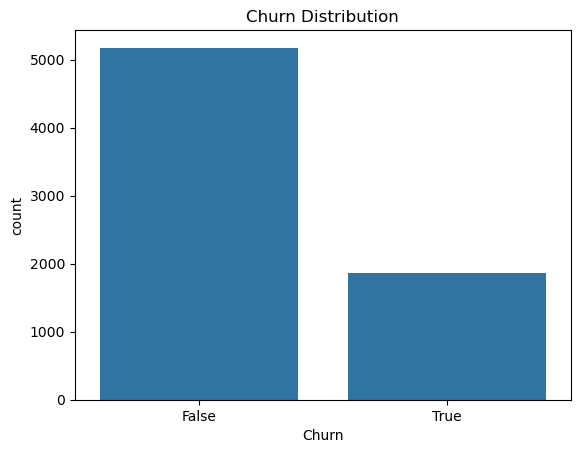

In [32]:
# Distribution of target variable
sns.countplot(data=data, x='Churn')
plt.title('Churn Distribution')
plt.show()


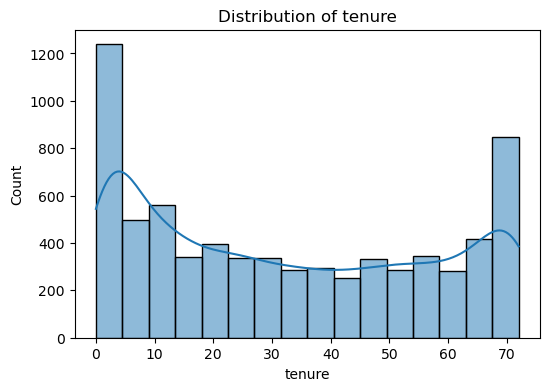

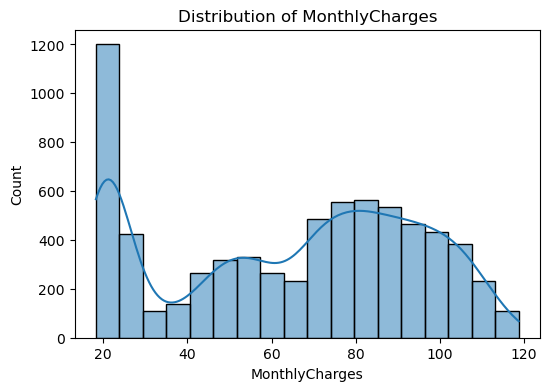

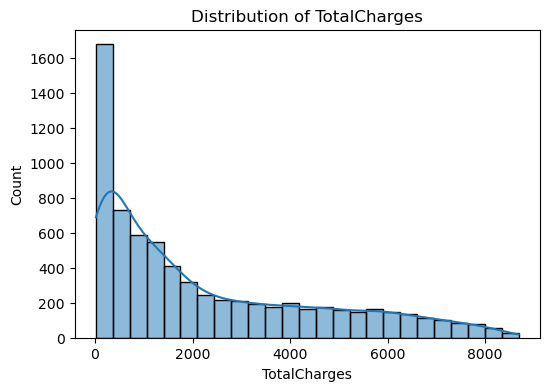

In [34]:
# Distribution of numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
for feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


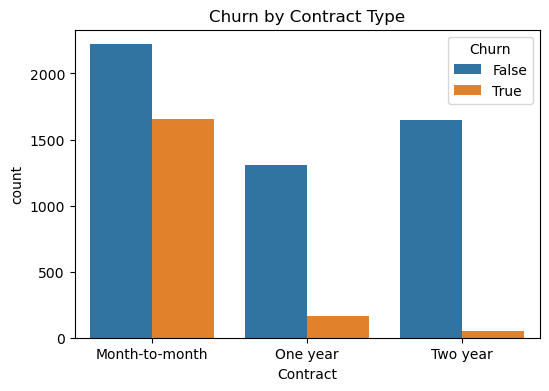

In [36]:
# Churn rate by contract type
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')
plt.show()

In [38]:
print("\nChurn Rate by Contract Type:")
print(data.groupby('Contract')['Churn'].mean() * 100)


Churn Rate by Contract Type:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64


In [40]:
print("\nObservation: Customers with month-to-month contracts are significantly more likely to churn compared to those with longer-term contracts.")


Observation: Customers with month-to-month contracts are significantly more likely to churn compared to those with longer-term contracts.


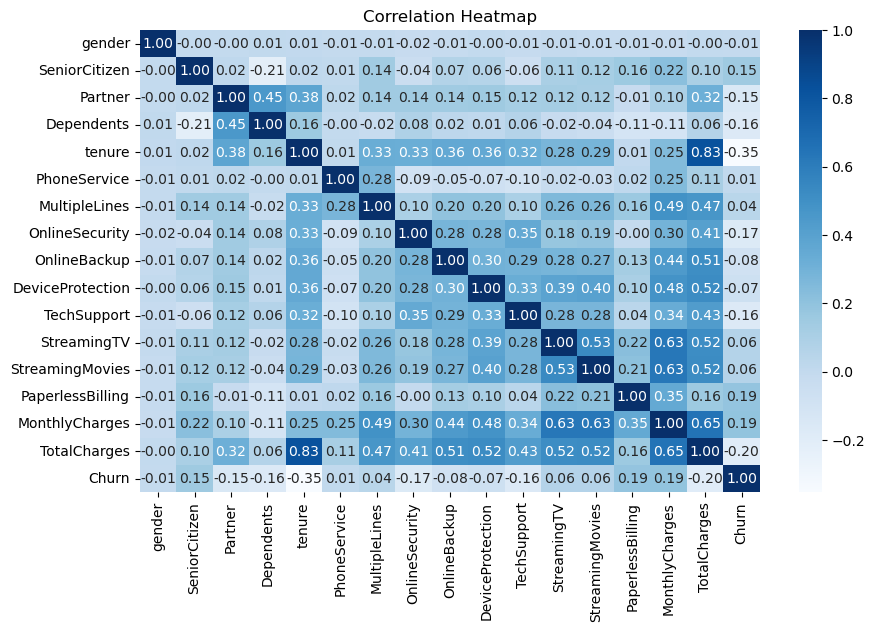

In [42]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()


Data Preprocessing

In [45]:
data.drop(['customerID'], axis=1, inplace=True)


In [47]:
# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

Feature Selection

In [50]:
X = data.drop('Churn', axis=1)
y = data['Churn'].astype(int)  # Ensure target is integer for correct predict_proba behavior


 Train-Test Split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Feature Scaling

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
#Rewrap for LIME explainability
X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
X_test = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

Hyperparameter Tuning with GridSearchCV

In [64]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

Model Training

In [67]:
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

model = grid_search.best_estimator_



Best Hyperparameters:
{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


Evaluation

In [70]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1035
           1       0.66      0.39      0.49       374

    accuracy                           0.78      1409
   macro avg       0.73      0.66      0.68      1409
weighted avg       0.77      0.78      0.76      1409

Confusion Matrix:
 [[961  74]
 [229 145]]
ROC-AUC Score: 0.8455320468108193


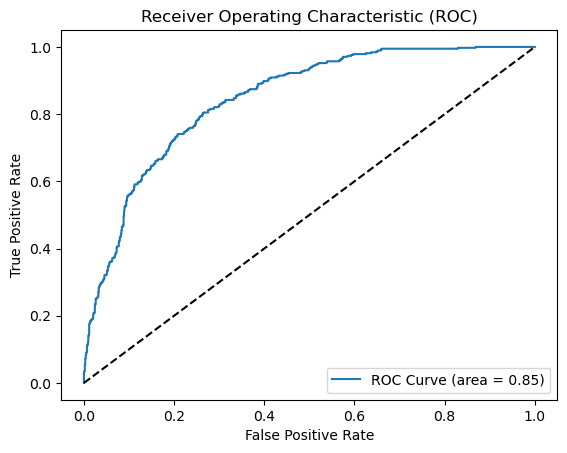

In [72]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


Feature Importance Visualization

In [75]:
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)


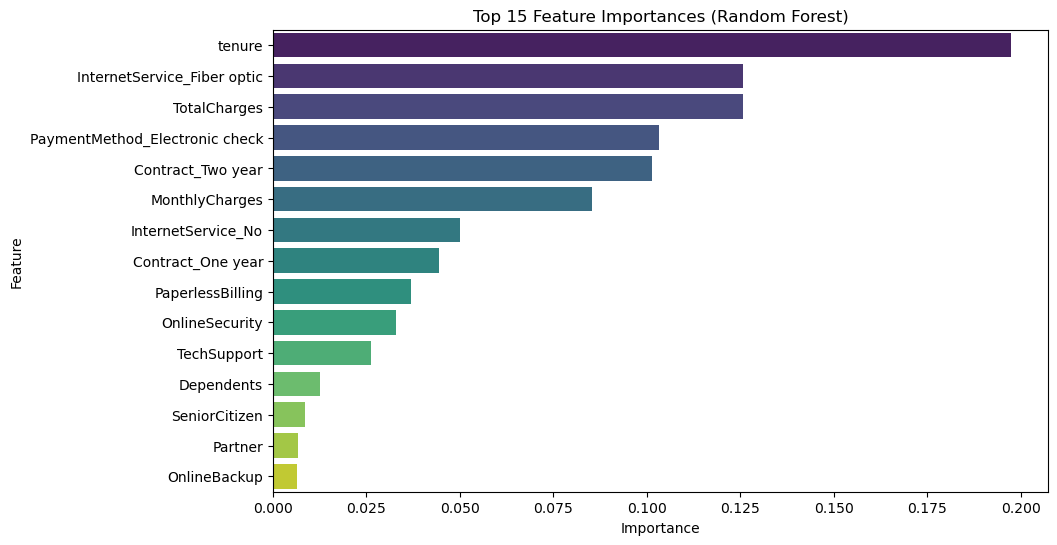

In [77]:
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

LIME Explainability

In [80]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    mode='classification'
)

# Pick a sample from the test set
sample_idx = 0
sample = X_test.iloc[sample_idx].values.reshape(1, -1)

exp = explainer.explain_instance(X_test.iloc[sample_idx].values, model.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

C:\Users\Dell\Documents\anac\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [151]:


from collections import Counter

# Analyze top features across multiple samples
feature_contributions = Counter()
def predict_with_names(x):
    return model.predict_proba(pd.DataFrame(x, columns=X.columns))

for i in range(20):  # You can increase this number for a broader view
    explanation = explainer.explain_instance(
        X_test.iloc[i].values,
        predict_with_names,
        num_features=10
    )
    for feature, weight in explanation.as_list():
        feature_contributions[feature] += abs(weight)  # Use abs to reflect importance regardless of direction

# Display top features contributing across samples
print("\nTop LIME Feature Contributions (aggregated across 20 samples):")
for feature, total_weight in feature_contributions.most_common(10):
    print(f"{feature}: {total_weight:.3f}")


Top LIME Feature Contributions (aggregated across 20 samples):
Contract_Two year <= -0.56: 1.444
-0.89 < InternetService_Fiber optic <= 1.13: 1.284
InternetService_Fiber optic <= -0.89: 1.044
PaymentMethod_Electronic check <= -0.71: 1.007
Contract_One year <= -0.51: 0.973
InternetService_No <= -0.52: 0.965
Contract_Two year > -0.56: 0.623
tenure > 0.92: 0.537
OnlineSecurity <= -0.64: 0.386
TechSupport <= -0.64: 0.316


Aggregating across 20 samples gives us a list of features which are likely globally important.

In [82]:
# Step 13: Save the Model
joblib.dump(model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.
